In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:64'

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models.efficientnet as efficientnet
from tqdm import tqdm
from torch.nn import Linear
from torch.nn.functional import l1_loss
from torch import optim
from torch.utils.data import DataLoader
from statistics import mean
from copy import deepcopy
from utils import (
    Dataset,
    TrainResult,
    TestResult,
    weighted_mse_loss,
    train_transform,
    test_transform
)

c:\Users\yrasi\OneDrive\Документы\mlSandbox\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
df = pd.read_parquet('train.pqt')

In [5]:
samples = []
samples_sizes = [len(df) // 5] * 5
samples_sizes[-1] += len(df) % samples_sizes[-1]
for size in samples_sizes:
    samples.append(df.sample(size, weights=df['weight']))
    df.drop(samples[-1].index, inplace=True)
    samples[-1].reset_index(drop=True, inplace=True)

In [8]:
model = efficientnet.efficientnet_v2_s(weights=efficientnet.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
model.classifier[1] = Linear(model.classifier[1].in_features, 1)

In [9]:
model.requires_grad_(True)
model = model.train().to(device)

all_params = sum(param.numel() for param in model.parameters())
grad_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print(all_params)
print(grad_params)

20178769
20178769


In [11]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer, batch_size) -> TrainResult:
    model.train()

    size = len(dataloader.dataset)
    size_batches = len(dataloader)
    checkpoint = 100
    running_loss = 0.0
    running_diff = 0.0
    losses = []
    diffs = []
    min_rate = float('inf')
    max_rate = float('-inf')

    for batch, (x, y, w) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        w = w.to(device)

        pred = model(x)
        loss = loss_fn(pred, y, w)
        diff = l1_loss(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        min_ = pred.detach().flatten().min().item()
        max_ = pred.detach().flatten().max().item()
        if min_ < min_rate:
            min_rate = min_
        if max_ > max_rate:
            max_rate = max_

        running_loss += loss.item()
        running_diff += diff
        is_last_batch = batch + 1 == size_batches
        batch_edge = ((batch + 1) % checkpoint) or checkpoint

        if is_last_batch or batch_edge == checkpoint:
            current = (batch * batch_size) + len(x)
            point_loss = running_loss / batch_edge
            point_diff = running_diff / batch_edge
            losses.append(point_loss)
            diffs.append(point_diff)
            print(f"Avg diff: {point_diff:>1f}, Avg loss: {point_loss:>1f}, Min rate: {min_rate:>1f}, Max rate: {max_rate:>1f}  [{current:>5d}/{size:>5d}]")
            running_loss = 0.0
            running_diff = 0.0
            min_rate = float('inf')
            max_rate = float('-inf')

    return TrainResult(losses, diffs)

In [14]:
def test_loop(dataloader, model, loss_fn) -> TestResult:
    model.eval()

    size = len(dataloader.dataset)
    running_loss = .0
    accuracy = .0
    min_rate = float('inf')
    max_rate = float('-inf')
    max_diff = float('-inf')
    plot_x = np.array([], dtype=np.float32)
    plot_y = np.array([], dtype=np.float32)

    with torch.no_grad():
        for x, y, w in tqdm(dataloader):
            x = x.to(device)
            y = y.to(device)
            w = w.to(device)

            pred = model(x)
            loss = loss_fn(pred, y, w)
            running_loss += loss.item() * y.shape[0]

            diffs = (pred - y).flatten()
            max_diff_ = diffs.absolute().max().item()
            max_diff = max_diff_ if max_diff_ > max_diff else max_diff

            accuracy += diffs.absolute().sum().item()
            min_ = pred.flatten().min().item()
            max_ = pred.flatten().max().item()
            if min_ < min_rate:
                min_rate = min_
            if max_ > max_rate:
                max_rate = max_

            plot_x = np.concatenate([plot_x, y.flatten().cpu().numpy()])
            plot_y = np.concatenate([plot_y, diffs.cpu().numpy()])

    running_loss /= size
    running_diff = accuracy / size
    accuracy = running_diff * 2 if running_diff else 0.0

    df = pd.DataFrame({'rate': plot_x, 'diffs': plot_y})
    df['abs_diffs'] = df['diffs'].copy().abs()
    df['range'] = pd.cut(df['rate'], bins=np.arange(0.0, 1.001, 0.05)).apply(lambda x: x.right)
    df = df.groupby('range', as_index=False).mean()

    return TestResult(accuracy, running_loss, running_diff, min_rate, max_rate, max_diff, df)

In [15]:
batch_size = 8
epochs = []
train_y = []
test_y = []
best_state = {
    'accuracy': float('-inf'),
    'loss': float('inf'),
    'diff': float('inf'),
    'min_rate': float('inf'),
    'max_rate': float('-inf'),
    'max_diff': float('-inf'),
    'epoch': None,
    'state': None
}
results_template = 'Test Results: \n Accuracy: {:>1f}, Avg loss: {:>1f}, Min rate: {:>1f}, Max rate: {:>1f}, Max diff {:>1f}'

Epoch 1
-------------------------------

k-1
Avg diff: 0.214162, Avg loss: 0.081382, Min rate: -0.129361, Max rate: 1.339566  [  800/ 3630]
Avg diff: 0.180934, Avg loss: 0.063762, Min rate: -0.253670, Max rate: 1.095914  [ 1600/ 3630]
Avg diff: 0.165258, Avg loss: 0.051338, Min rate: 0.090705, Max rate: 1.118280  [ 2400/ 3630]
Avg diff: 0.150292, Avg loss: 0.042704, Min rate: 0.024272, Max rate: 1.125050  [ 3200/ 3630]
Avg diff: 0.146686, Avg loss: 0.040991, Min rate: -0.055510, Max rate: 1.008728  [ 3630/ 3630]


100%|██████████| 114/114 [00:15<00:00,  7.13it/s]



k-2
Avg diff: 0.150496, Avg loss: 0.043234, Min rate: 0.118537, Max rate: 1.075452  [  800/ 3630]
Avg diff: 0.146051, Avg loss: 0.043078, Min rate: -0.087742, Max rate: 1.130268  [ 1600/ 3630]
Avg diff: 0.147214, Avg loss: 0.045299, Min rate: -0.086194, Max rate: 1.158477  [ 2400/ 3630]
Avg diff: 0.136036, Avg loss: 0.038261, Min rate: 0.025556, Max rate: 1.054570  [ 3200/ 3630]
Avg diff: 0.133579, Avg loss: 0.035090, Min rate: 0.071656, Max rate: 1.035865  [ 3630/ 3630]


100%|██████████| 114/114 [00:16<00:00,  7.06it/s]



k-3
Avg diff: 0.135614, Avg loss: 0.034688, Min rate: -0.118099, Max rate: 0.998600  [  800/ 3630]
Avg diff: 0.137374, Avg loss: 0.037025, Min rate: -0.040720, Max rate: 1.138844  [ 1600/ 3630]
Avg diff: 0.127696, Avg loss: 0.031468, Min rate: 0.036563, Max rate: 1.100451  [ 2400/ 3630]
Avg diff: 0.134111, Avg loss: 0.035307, Min rate: -0.192630, Max rate: 1.110487  [ 3200/ 3630]
Avg diff: 0.143275, Avg loss: 0.041617, Min rate: 0.112569, Max rate: 1.181889  [ 3630/ 3630]


100%|██████████| 114/114 [00:16<00:00,  7.01it/s]



k-4
Avg diff: 0.132912, Avg loss: 0.032662, Min rate: -0.005722, Max rate: 1.055654  [  800/ 3630]
Avg diff: 0.136480, Avg loss: 0.034216, Min rate: -0.159256, Max rate: 1.038759  [ 1600/ 3630]
Avg diff: 0.132935, Avg loss: 0.036593, Min rate: -0.048363, Max rate: 1.045862  [ 2400/ 3630]
Avg diff: 0.129384, Avg loss: 0.032346, Min rate: -0.017489, Max rate: 1.169218  [ 3200/ 3630]
Avg diff: 0.126152, Avg loss: 0.030798, Min rate: -0.083006, Max rate: 0.957204  [ 3630/ 3630]


100%|██████████| 114/114 [00:16<00:00,  6.71it/s]



k-5
Avg diff: 0.132900, Avg loss: 0.035893, Min rate: -0.157906, Max rate: 1.121327  [  800/ 3628]
Avg diff: 0.138433, Avg loss: 0.040700, Min rate: -0.037163, Max rate: 1.152374  [ 1600/ 3628]
Avg diff: 0.125868, Avg loss: 0.028624, Min rate: -0.110333, Max rate: 1.103963  [ 2400/ 3628]
Avg diff: 0.124110, Avg loss: 0.029944, Min rate: -0.028809, Max rate: 1.115340  [ 3200/ 3628]
Avg diff: 0.118487, Avg loss: 0.025553, Min rate: -0.030231, Max rate: 1.072090  [ 3628/ 3628]


100%|██████████| 114/114 [00:16<00:00,  6.81it/s]
C:\Users\yrasi\AppData\Local\Temp\ipykernel_4104\2076441446.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('range', as_index=False).mean()


Test Results: 
 Accuracy: 0.252134, Avg loss: 0.031922, Min rate: -0.029240, Max rate: 1.046547, Max diff 0.664580


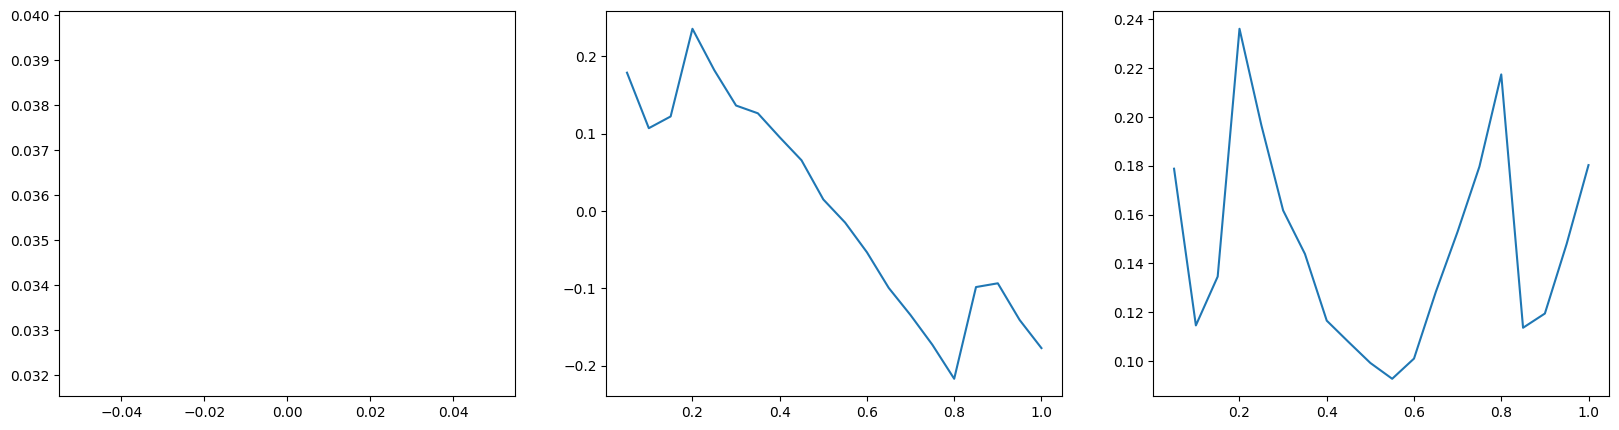

Epoch 2
-------------------------------

k-1
Avg diff: 0.112857, Avg loss: 0.021916, Min rate: 0.007119, Max rate: 1.103534  [  800/ 3630]
Avg diff: 0.113485, Avg loss: 0.023275, Min rate: -0.182463, Max rate: 1.149915  [ 1600/ 3630]
Avg diff: 0.111024, Avg loss: 0.020939, Min rate: 0.044287, Max rate: 1.083573  [ 2400/ 3630]
Avg diff: 0.107117, Avg loss: 0.019542, Min rate: -0.013880, Max rate: 1.193834  [ 3200/ 3630]
Avg diff: 0.114623, Avg loss: 0.022373, Min rate: -0.045386, Max rate: 1.110839  [ 3630/ 3630]


100%|██████████| 114/114 [00:16<00:00,  6.95it/s]



k-2
Avg diff: 0.114832, Avg loss: 0.022800, Min rate: -0.153918, Max rate: 1.134761  [  800/ 3630]
Avg diff: 0.115407, Avg loss: 0.024589, Min rate: -0.063226, Max rate: 1.107265  [ 1600/ 3630]
Avg diff: 0.110421, Avg loss: 0.022604, Min rate: -0.097740, Max rate: 1.106627  [ 2400/ 3630]
Avg diff: 0.112410, Avg loss: 0.023284, Min rate: -0.022895, Max rate: 1.171953  [ 3200/ 3630]
Avg diff: 0.112104, Avg loss: 0.022618, Min rate: -0.042094, Max rate: 0.951974  [ 3630/ 3630]


100%|██████████| 114/114 [00:16<00:00,  6.96it/s]



k-3
Avg diff: 0.106369, Avg loss: 0.020096, Min rate: -0.016590, Max rate: 1.193885  [  800/ 3630]
Avg diff: 0.110692, Avg loss: 0.022510, Min rate: -0.094186, Max rate: 1.048376  [ 1600/ 3630]
Avg diff: 0.111079, Avg loss: 0.023503, Min rate: -0.063228, Max rate: 1.096103  [ 2400/ 3630]
Avg diff: 0.111514, Avg loss: 0.021700, Min rate: -0.045642, Max rate: 1.099051  [ 3200/ 3630]
Avg diff: 0.109711, Avg loss: 0.020116, Min rate: -0.049942, Max rate: 0.978403  [ 3630/ 3630]


100%|██████████| 114/114 [00:14<00:00,  7.84it/s]



k-4
Avg diff: 0.105771, Avg loss: 0.019717, Min rate: -0.081161, Max rate: 1.070120  [  800/ 3630]
Avg diff: 0.109486, Avg loss: 0.022400, Min rate: -0.038672, Max rate: 1.072867  [ 1600/ 3630]
Avg diff: 0.102995, Avg loss: 0.017674, Min rate: -0.081795, Max rate: 1.107134  [ 2400/ 3630]
Avg diff: 0.107560, Avg loss: 0.021265, Min rate: -0.129109, Max rate: 1.070059  [ 3200/ 3630]
Avg diff: 0.105736, Avg loss: 0.019331, Min rate: 0.031979, Max rate: 1.097012  [ 3630/ 3630]


100%|██████████| 114/114 [00:16<00:00,  7.12it/s]



k-5
Avg diff: 0.100112, Avg loss: 0.016599, Min rate: -0.123850, Max rate: 1.141974  [  800/ 3628]
Avg diff: 0.103247, Avg loss: 0.018259, Min rate: -0.000759, Max rate: 1.097075  [ 1600/ 3628]
Avg diff: 0.106382, Avg loss: 0.020276, Min rate: -0.070705, Max rate: 1.050366  [ 2400/ 3628]
Avg diff: 0.106316, Avg loss: 0.021326, Min rate: -0.037823, Max rate: 1.094869  [ 3200/ 3628]
Avg diff: 0.112278, Avg loss: 0.025593, Min rate: -0.028985, Max rate: 1.053525  [ 3628/ 3628]


100%|██████████| 114/114 [00:16<00:00,  7.11it/s]
C:\Users\yrasi\AppData\Local\Temp\ipykernel_4104\2076441446.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('range', as_index=False).mean()


Test Results: 
 Accuracy: 0.200230, Avg loss: 0.017217, Min rate: -0.062946, Max rate: 1.123016, Max diff 0.646047


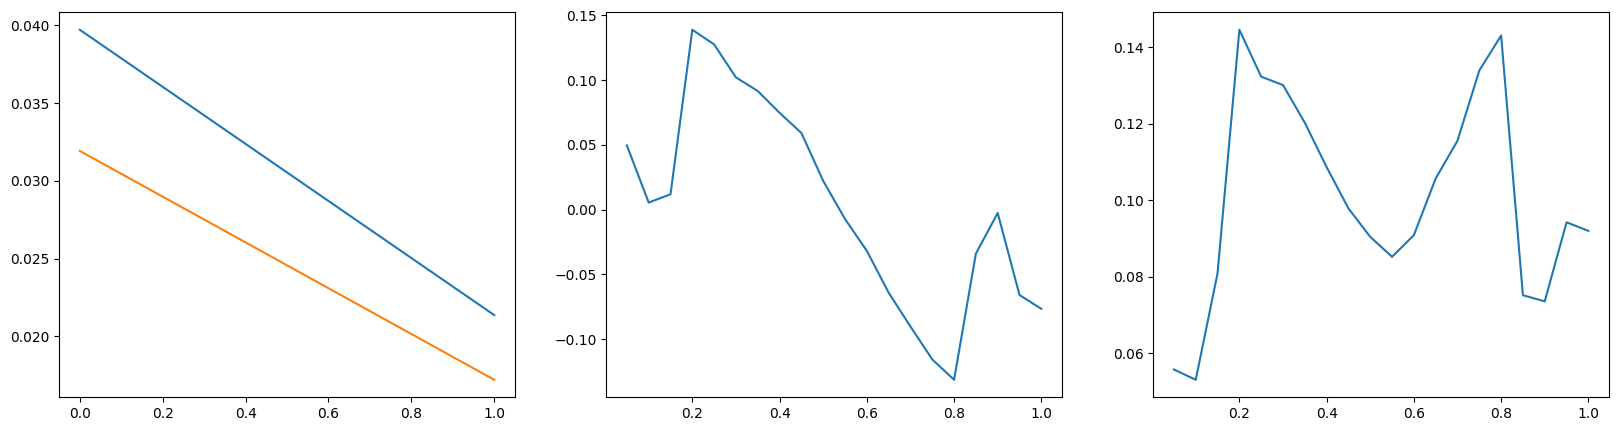

Epoch 3
-------------------------------

k-1
Avg diff: 0.098571, Avg loss: 0.015888, Min rate: -0.014025, Max rate: 1.114721  [  800/ 3630]
Avg diff: 0.096735, Avg loss: 0.015021, Min rate: -0.043371, Max rate: 1.124008  [ 1600/ 3630]
Avg diff: 0.096260, Avg loss: 0.014953, Min rate: 0.004437, Max rate: 1.170142  [ 2400/ 3630]
Avg diff: 0.096247, Avg loss: 0.016350, Min rate: -0.049916, Max rate: 1.157637  [ 3200/ 3630]
Avg diff: 0.111450, Avg loss: 0.018684, Min rate: -0.064450, Max rate: 0.962113  [ 3630/ 3630]


100%|██████████| 114/114 [00:16<00:00,  7.11it/s]



k-2
Avg diff: 0.092790, Avg loss: 0.014993, Min rate: -0.021399, Max rate: 1.093722  [  800/ 3630]
Avg diff: 0.097706, Avg loss: 0.017386, Min rate: -0.046933, Max rate: 1.125908  [ 1600/ 3630]
Avg diff: 0.097942, Avg loss: 0.015140, Min rate: -0.036031, Max rate: 1.227346  [ 2400/ 3630]
Avg diff: 0.097158, Avg loss: 0.015080, Min rate: 0.028341, Max rate: 1.088652  [ 3200/ 3630]
Avg diff: 0.096924, Avg loss: 0.016802, Min rate: -0.025984, Max rate: 1.140579  [ 3630/ 3630]


100%|██████████| 114/114 [00:15<00:00,  7.15it/s]



k-3
Avg diff: 0.086402, Avg loss: 0.013090, Min rate: -0.034216, Max rate: 1.064330  [  800/ 3630]
Avg diff: 0.095494, Avg loss: 0.014884, Min rate: -0.032245, Max rate: 1.105214  [ 1600/ 3630]
Avg diff: 0.092279, Avg loss: 0.014554, Min rate: -0.104664, Max rate: 1.073175  [ 2400/ 3630]
Avg diff: 0.094945, Avg loss: 0.014770, Min rate: 0.010175, Max rate: 1.072551  [ 3200/ 3630]
Avg diff: 0.094575, Avg loss: 0.014425, Min rate: -0.026531, Max rate: 1.085047  [ 3630/ 3630]


100%|██████████| 114/114 [00:15<00:00,  7.60it/s]



k-4
Avg diff: 0.090493, Avg loss: 0.013776, Min rate: -0.043924, Max rate: 1.093894  [  800/ 3630]
Avg diff: 0.090632, Avg loss: 0.013396, Min rate: -0.133571, Max rate: 1.156385  [ 1600/ 3630]
Avg diff: 0.091139, Avg loss: 0.014194, Min rate: -0.102857, Max rate: 1.013073  [ 2400/ 3630]
Avg diff: 0.092871, Avg loss: 0.015813, Min rate: -0.061471, Max rate: 1.140020  [ 3200/ 3630]
Avg diff: 0.100783, Avg loss: 0.018473, Min rate: -0.107605, Max rate: 1.153309  [ 3630/ 3630]


100%|██████████| 114/114 [00:15<00:00,  7.26it/s]



k-5
Avg diff: 0.088251, Avg loss: 0.013070, Min rate: -0.023147, Max rate: 1.165075  [  800/ 3628]
Avg diff: 0.092091, Avg loss: 0.014543, Min rate: -0.032507, Max rate: 1.064482  [ 1600/ 3628]
Avg diff: 0.097861, Avg loss: 0.017000, Min rate: -0.053176, Max rate: 1.094915  [ 2400/ 3628]
Avg diff: 0.089526, Avg loss: 0.013420, Min rate: -0.064135, Max rate: 1.078565  [ 3200/ 3628]
Avg diff: 0.089484, Avg loss: 0.012950, Min rate: -0.044994, Max rate: 1.088380  [ 3628/ 3628]


100%|██████████| 114/114 [00:15<00:00,  7.58it/s]
C:\Users\yrasi\AppData\Local\Temp\ipykernel_4104\2076441446.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('range', as_index=False).mean()


Test Results: 
 Accuracy: 0.167820, Avg loss: 0.011546, Min rate: -0.046305, Max rate: 1.109267, Max diff 0.515664


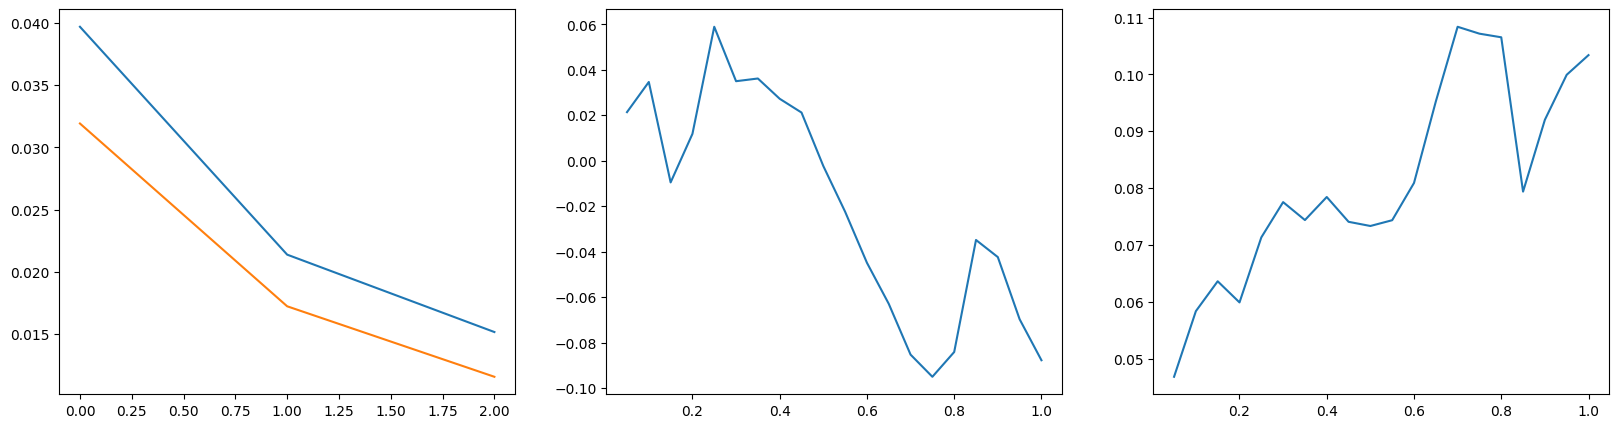

Epoch 4
-------------------------------

k-1
Avg diff: 0.081868, Avg loss: 0.010129, Min rate: 0.031270, Max rate: 1.083684  [  800/ 3630]
Avg diff: 0.083842, Avg loss: 0.011161, Min rate: 0.001499, Max rate: 1.100113  [ 1600/ 3630]
Avg diff: 0.083501, Avg loss: 0.011181, Min rate: -0.018884, Max rate: 1.055892  [ 2400/ 3630]
Avg diff: 0.083670, Avg loss: 0.010553, Min rate: -0.087709, Max rate: 1.060968  [ 3200/ 3630]
Avg diff: 0.081628, Avg loss: 0.010180, Min rate: 0.032104, Max rate: 1.077505  [ 3630/ 3630]


100%|██████████| 114/114 [00:14<00:00,  7.62it/s]



k-2
Avg diff: 0.081000, Avg loss: 0.010005, Min rate: -0.022702, Max rate: 1.161054  [  800/ 3630]
Avg diff: 0.077817, Avg loss: 0.009716, Min rate: -0.025651, Max rate: 1.145527  [ 1600/ 3630]
Avg diff: 0.078354, Avg loss: 0.010260, Min rate: -0.043080, Max rate: 1.156155  [ 2400/ 3630]
Avg diff: 0.082045, Avg loss: 0.010880, Min rate: -0.001580, Max rate: 1.042172  [ 3200/ 3630]
Avg diff: 0.085058, Avg loss: 0.011147, Min rate: 0.011780, Max rate: 1.043918  [ 3630/ 3630]


100%|██████████| 114/114 [00:14<00:00,  7.87it/s]



k-3
Avg diff: 0.081566, Avg loss: 0.010578, Min rate: -0.049868, Max rate: 1.085295  [  800/ 3630]
Avg diff: 0.076872, Avg loss: 0.009587, Min rate: 0.011149, Max rate: 1.111625  [ 1600/ 3630]
Avg diff: 0.082723, Avg loss: 0.011648, Min rate: -0.035356, Max rate: 1.054337  [ 2400/ 3630]
Avg diff: 0.080052, Avg loss: 0.010393, Min rate: -0.026901, Max rate: 1.051943  [ 3200/ 3630]
Avg diff: 0.078253, Avg loss: 0.010277, Min rate: 0.055332, Max rate: 1.030424  [ 3630/ 3630]


100%|██████████| 114/114 [00:15<00:00,  7.40it/s]



k-4
Avg diff: 0.078491, Avg loss: 0.009985, Min rate: -0.041780, Max rate: 1.086943  [  800/ 3630]
Avg diff: 0.076432, Avg loss: 0.009805, Min rate: -0.045135, Max rate: 1.110830  [ 1600/ 3630]
Avg diff: 0.081150, Avg loss: 0.011089, Min rate: -0.046666, Max rate: 1.064833  [ 2400/ 3630]
Avg diff: 0.073924, Avg loss: 0.008998, Min rate: -0.049203, Max rate: 1.113753  [ 3200/ 3630]
Avg diff: 0.086669, Avg loss: 0.013009, Min rate: -0.069511, Max rate: 1.018188  [ 3630/ 3630]


100%|██████████| 114/114 [00:15<00:00,  7.33it/s]



k-5
Avg diff: 0.088447, Avg loss: 0.014314, Min rate: 0.001650, Max rate: 1.087947  [  800/ 3628]
Avg diff: 0.083755, Avg loss: 0.011751, Min rate: -0.020540, Max rate: 1.084693  [ 1600/ 3628]
Avg diff: 0.078479, Avg loss: 0.011303, Min rate: -0.025861, Max rate: 1.081531  [ 2400/ 3628]
Avg diff: 0.081082, Avg loss: 0.011094, Min rate: -0.034660, Max rate: 1.072201  [ 3200/ 3628]
Avg diff: 0.076087, Avg loss: 0.009597, Min rate: 0.025395, Max rate: 1.052557  [ 3628/ 3628]


100%|██████████| 114/114 [00:15<00:00,  7.43it/s]
C:\Users\yrasi\AppData\Local\Temp\ipykernel_4104\2076441446.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('range', as_index=False).mean()


Test Results: 
 Accuracy: 0.137124, Avg loss: 0.007080, Min rate: -0.021641, Max rate: 1.088685, Max diff 0.392898


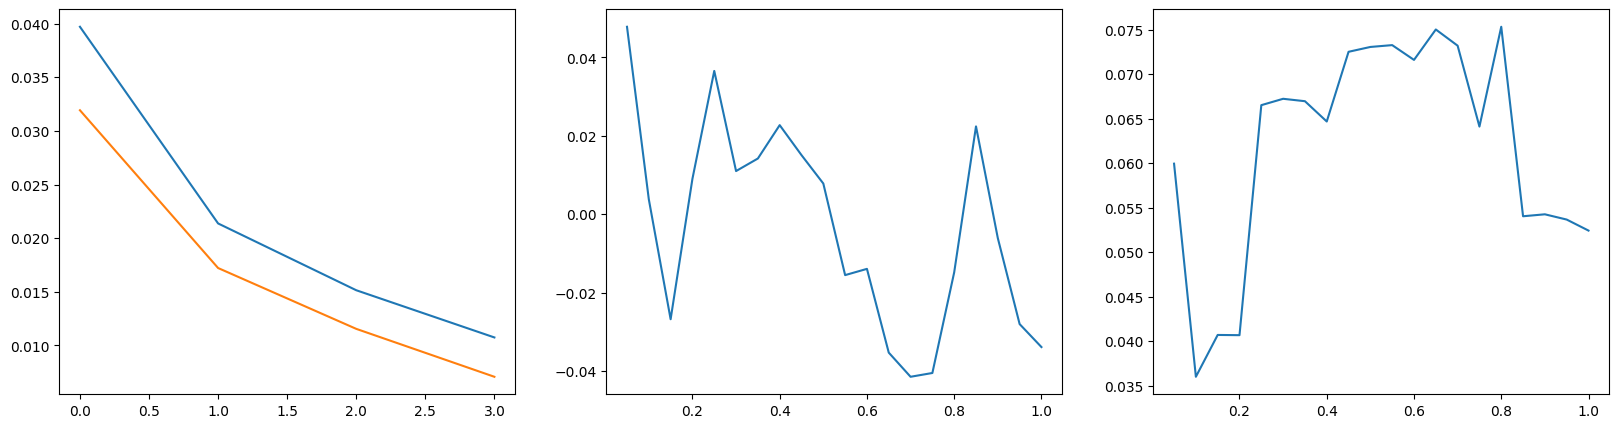

Epoch 5
-------------------------------

k-1
Avg diff: 0.072083, Avg loss: 0.007887, Min rate: -0.016335, Max rate: 1.071848  [  800/ 3630]
Avg diff: 0.074570, Avg loss: 0.008660, Min rate: -0.017071, Max rate: 1.062323  [ 1600/ 3630]
Avg diff: 0.072159, Avg loss: 0.008024, Min rate: -0.010160, Max rate: 1.079504  [ 2400/ 3630]
Avg diff: 0.070136, Avg loss: 0.007837, Min rate: 0.006428, Max rate: 1.034777  [ 3200/ 3630]
Avg diff: 0.072171, Avg loss: 0.007543, Min rate: 0.054165, Max rate: 1.072699  [ 3630/ 3630]


100%|██████████| 114/114 [00:15<00:00,  7.51it/s]



k-2
Avg diff: 0.065365, Avg loss: 0.006558, Min rate: -0.019808, Max rate: 1.076885  [  800/ 3630]
Avg diff: 0.068594, Avg loss: 0.007658, Min rate: -0.065744, Max rate: 1.105952  [ 1600/ 3630]
Avg diff: 0.072481, Avg loss: 0.008185, Min rate: 0.011126, Max rate: 1.098664  [ 2400/ 3630]
Avg diff: 0.075039, Avg loss: 0.009349, Min rate: -0.060493, Max rate: 1.063211  [ 3200/ 3630]
Avg diff: 0.077393, Avg loss: 0.009772, Min rate: 0.032479, Max rate: 1.110027  [ 3630/ 3630]


100%|██████████| 114/114 [00:14<00:00,  7.89it/s]



k-3
Avg diff: 0.071501, Avg loss: 0.008654, Min rate: -0.014833, Max rate: 1.103258  [  800/ 3630]
Avg diff: 0.072068, Avg loss: 0.009580, Min rate: -0.065461, Max rate: 1.097310  [ 1600/ 3630]
Avg diff: 0.075864, Avg loss: 0.009408, Min rate: -0.018453, Max rate: 1.095671  [ 2400/ 3630]
Avg diff: 0.073646, Avg loss: 0.008945, Min rate: -0.107990, Max rate: 1.058238  [ 3200/ 3630]
Avg diff: 0.070576, Avg loss: 0.007867, Min rate: 0.025758, Max rate: 1.068844  [ 3630/ 3630]


100%|██████████| 114/114 [00:14<00:00,  7.74it/s]



k-4
Avg diff: 0.070886, Avg loss: 0.008430, Min rate: -0.014792, Max rate: 1.131175  [  800/ 3630]
Avg diff: 0.069929, Avg loss: 0.008022, Min rate: -0.005780, Max rate: 1.088227  [ 1600/ 3630]
Avg diff: 0.071024, Avg loss: 0.007970, Min rate: -0.005615, Max rate: 1.096342  [ 2400/ 3630]
Avg diff: 0.074655, Avg loss: 0.009528, Min rate: -0.026842, Max rate: 1.131055  [ 3200/ 3630]
Avg diff: 0.075563, Avg loss: 0.009883, Min rate: -0.016967, Max rate: 1.014788  [ 3630/ 3630]


100%|██████████| 114/114 [00:15<00:00,  7.42it/s]



k-5
Avg diff: 0.069753, Avg loss: 0.008570, Min rate: -0.035553, Max rate: 1.120246  [  800/ 3628]
Avg diff: 0.076541, Avg loss: 0.010039, Min rate: -0.018879, Max rate: 1.127368  [ 1600/ 3628]
Avg diff: 0.076326, Avg loss: 0.009264, Min rate: -0.028480, Max rate: 1.088724  [ 2400/ 3628]
Avg diff: 0.071003, Avg loss: 0.008587, Min rate: -0.008222, Max rate: 1.019388  [ 3200/ 3628]
Avg diff: 0.070386, Avg loss: 0.008332, Min rate: 0.015163, Max rate: 1.050268  [ 3628/ 3628]


100%|██████████| 114/114 [00:16<00:00,  6.97it/s]
C:\Users\yrasi\AppData\Local\Temp\ipykernel_4104\2076441446.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('range', as_index=False).mean()


Test Results: 
 Accuracy: 0.123088, Avg loss: 0.005780, Min rate: 0.023002, Max rate: 1.179750, Max diff 0.467937


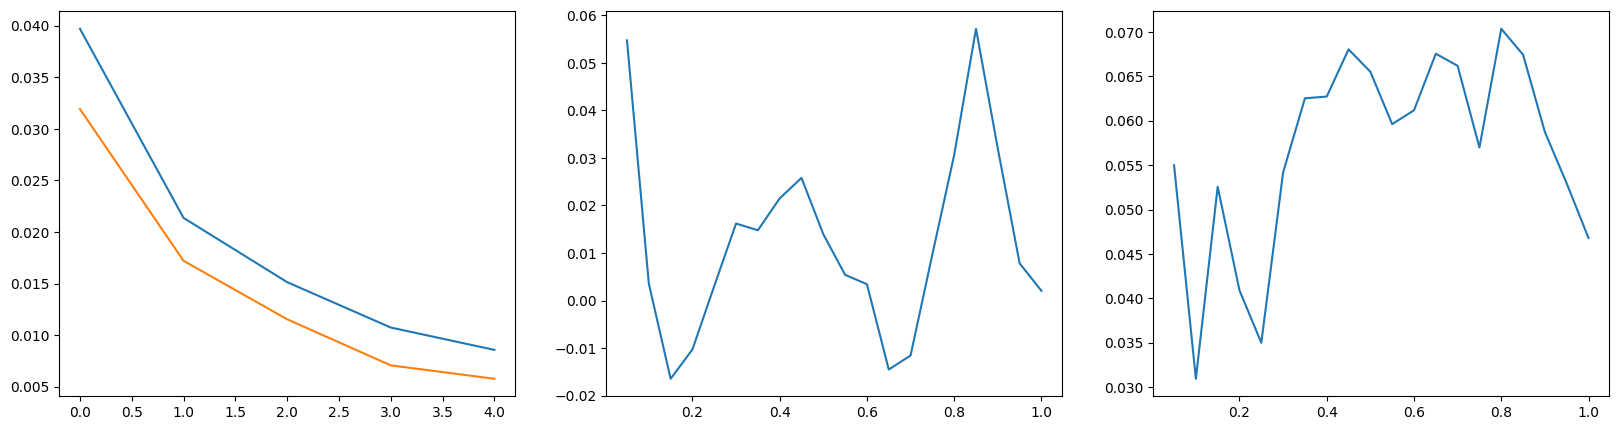

Epoch 6
-------------------------------

k-1
Avg diff: 0.063763, Avg loss: 0.006413, Min rate: 0.041535, Max rate: 1.050316  [  800/ 3630]
Avg diff: 0.067612, Avg loss: 0.006944, Min rate: -0.173250, Max rate: 1.084442  [ 1600/ 3630]
Avg diff: 0.065385, Avg loss: 0.006119, Min rate: 0.026610, Max rate: 1.038756  [ 2400/ 3630]
Avg diff: 0.061677, Avg loss: 0.006021, Min rate: -0.021446, Max rate: 1.040793  [ 3200/ 3630]
Avg diff: 0.064864, Avg loss: 0.006465, Min rate: -0.010762, Max rate: 1.037905  [ 3630/ 3630]


100%|██████████| 114/114 [00:15<00:00,  7.37it/s]



k-2
Avg diff: 0.066835, Avg loss: 0.007462, Min rate: -0.119386, Max rate: 1.068449  [  800/ 3630]
Avg diff: 0.067253, Avg loss: 0.007944, Min rate: 0.017259, Max rate: 1.134357  [ 1600/ 3630]
Avg diff: 0.083201, Avg loss: 0.012992, Min rate: 0.019655, Max rate: 1.140977  [ 2400/ 3630]
Avg diff: 0.079887, Avg loss: 0.011120, Min rate: 0.034728, Max rate: 1.031958  [ 3200/ 3630]
Avg diff: 0.080489, Avg loss: 0.011462, Min rate: 0.042388, Max rate: 0.978511  [ 3630/ 3630]


100%|██████████| 114/114 [00:14<00:00,  7.93it/s]



k-3
Avg diff: 0.072198, Avg loss: 0.009062, Min rate: -0.049011, Max rate: 1.145679  [  800/ 3630]
Avg diff: 0.069605, Avg loss: 0.008434, Min rate: -0.043239, Max rate: 1.030697  [ 1600/ 3630]
Avg diff: 0.070802, Avg loss: 0.008767, Min rate: -0.002473, Max rate: 1.035951  [ 2400/ 3630]
Avg diff: 0.065162, Avg loss: 0.006762, Min rate: 0.013669, Max rate: 1.058862  [ 3200/ 3630]
Avg diff: 0.068229, Avg loss: 0.007134, Min rate: -0.002101, Max rate: 1.046287  [ 3630/ 3630]


100%|██████████| 114/114 [00:14<00:00,  7.94it/s]



k-4
Avg diff: 0.065580, Avg loss: 0.007740, Min rate: -0.084790, Max rate: 1.048844  [  800/ 3630]
Avg diff: 0.066850, Avg loss: 0.007715, Min rate: -0.046017, Max rate: 1.075238  [ 1600/ 3630]
Avg diff: 0.067344, Avg loss: 0.007522, Min rate: -0.058843, Max rate: 1.030707  [ 2400/ 3630]
Avg diff: 0.065014, Avg loss: 0.007137, Min rate: 0.028705, Max rate: 1.127899  [ 3200/ 3630]
Avg diff: 0.066019, Avg loss: 0.006472, Min rate: -0.005922, Max rate: 1.037599  [ 3630/ 3630]


100%|██████████| 114/114 [00:15<00:00,  7.22it/s]



k-5
Avg diff: 0.058495, Avg loss: 0.005897, Min rate: -0.002394, Max rate: 1.038885  [  800/ 3628]
Avg diff: 0.062921, Avg loss: 0.006591, Min rate: 0.005053, Max rate: 1.085390  [ 1600/ 3628]
Avg diff: 0.064703, Avg loss: 0.006878, Min rate: -0.026601, Max rate: 1.066532  [ 2400/ 3628]
Avg diff: 0.060562, Avg loss: 0.005843, Min rate: -0.016506, Max rate: 1.085258  [ 3200/ 3628]
Avg diff: 0.063626, Avg loss: 0.006628, Min rate: 0.009897, Max rate: 1.005956  [ 3628/ 3628]


100%|██████████| 114/114 [00:15<00:00,  7.45it/s]
C:\Users\yrasi\AppData\Local\Temp\ipykernel_4104\2076441446.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('range', as_index=False).mean()


Test Results: 
 Accuracy: 0.121630, Avg loss: 0.005580, Min rate: -0.044016, Max rate: 1.137204, Max diff 0.350535


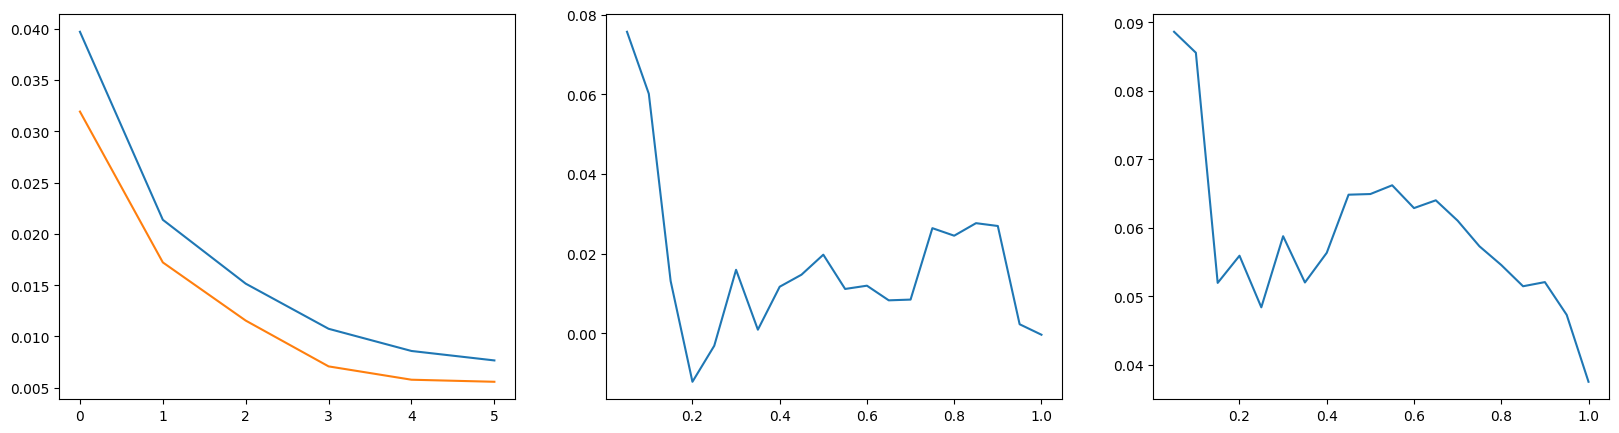

Epoch 7
-------------------------------

k-1
Avg diff: 0.058373, Avg loss: 0.005252, Min rate: -0.008191, Max rate: 1.011384  [  800/ 3630]
Avg diff: 0.058727, Avg loss: 0.005174, Min rate: 0.039485, Max rate: 1.033112  [ 1600/ 3630]
Avg diff: 0.058066, Avg loss: 0.005348, Min rate: -0.006081, Max rate: 1.017658  [ 2400/ 3630]
Avg diff: 0.061171, Avg loss: 0.005707, Min rate: 0.008794, Max rate: 1.037482  [ 3200/ 3630]
Avg diff: 0.059024, Avg loss: 0.005354, Min rate: -0.015046, Max rate: 1.051018  [ 3630/ 3630]


100%|██████████| 114/114 [00:13<00:00,  8.30it/s]



k-2
Avg diff: 0.056462, Avg loss: 0.005235, Min rate: 0.027946, Max rate: 1.145167  [  800/ 3630]
Avg diff: 0.057412, Avg loss: 0.005277, Min rate: 0.004655, Max rate: 1.065759  [ 1600/ 3630]
Avg diff: 0.059933, Avg loss: 0.005709, Min rate: 0.002593, Max rate: 1.065141  [ 2400/ 3630]
Avg diff: 0.061311, Avg loss: 0.007114, Min rate: -0.053256, Max rate: 1.061386  [ 3200/ 3630]
Avg diff: 0.068357, Avg loss: 0.008677, Min rate: 0.034124, Max rate: 1.071783  [ 3630/ 3630]


100%|██████████| 114/114 [00:16<00:00,  6.99it/s]



k-3
Avg diff: 0.063285, Avg loss: 0.006767, Min rate: -0.047813, Max rate: 1.047175  [  800/ 3630]
Avg diff: 0.058212, Avg loss: 0.005482, Min rate: -0.051189, Max rate: 1.058746  [ 1600/ 3630]
Avg diff: 0.059036, Avg loss: 0.005656, Min rate: -0.002323, Max rate: 1.020331  [ 2400/ 3630]
Avg diff: 0.062980, Avg loss: 0.006489, Min rate: -0.064313, Max rate: 1.030663  [ 3200/ 3630]
Avg diff: 0.062296, Avg loss: 0.006114, Min rate: 0.013666, Max rate: 1.044213  [ 3630/ 3630]


100%|██████████| 114/114 [00:16<00:00,  6.90it/s]



k-4
Avg diff: 0.055832, Avg loss: 0.005432, Min rate: -0.020408, Max rate: 1.041748  [  800/ 3630]
Avg diff: 0.055464, Avg loss: 0.005275, Min rate: 0.010786, Max rate: 1.060395  [ 1600/ 3630]
Avg diff: 0.056862, Avg loss: 0.005180, Min rate: -0.185035, Max rate: 1.079319  [ 2400/ 3630]
Avg diff: 0.058143, Avg loss: 0.005307, Min rate: -0.008164, Max rate: 1.057424  [ 3200/ 3630]
Avg diff: 0.064888, Avg loss: 0.006711, Min rate: 0.019462, Max rate: 1.137534  [ 3630/ 3630]


100%|██████████| 114/114 [00:17<00:00,  6.41it/s]



k-5
Avg diff: 0.058992, Avg loss: 0.005558, Min rate: -0.017239, Max rate: 1.051389  [  800/ 3628]
Avg diff: 0.057769, Avg loss: 0.005593, Min rate: -0.000058, Max rate: 1.100075  [ 1600/ 3628]
Avg diff: 0.057936, Avg loss: 0.005725, Min rate: 0.014791, Max rate: 1.019632  [ 2400/ 3628]
Avg diff: 0.061727, Avg loss: 0.006461, Min rate: -0.027753, Max rate: 1.032076  [ 3200/ 3628]
Avg diff: 0.057024, Avg loss: 0.005662, Min rate: -0.007873, Max rate: 0.994384  [ 3628/ 3628]


100%|██████████| 114/114 [00:14<00:00,  7.63it/s]
C:\Users\yrasi\AppData\Local\Temp\ipykernel_4104\2076441446.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('range', as_index=False).mean()


Test Results: 
 Accuracy: 0.111645, Avg loss: 0.004849, Min rate: -0.035152, Max rate: 1.100596, Max diff 0.307330


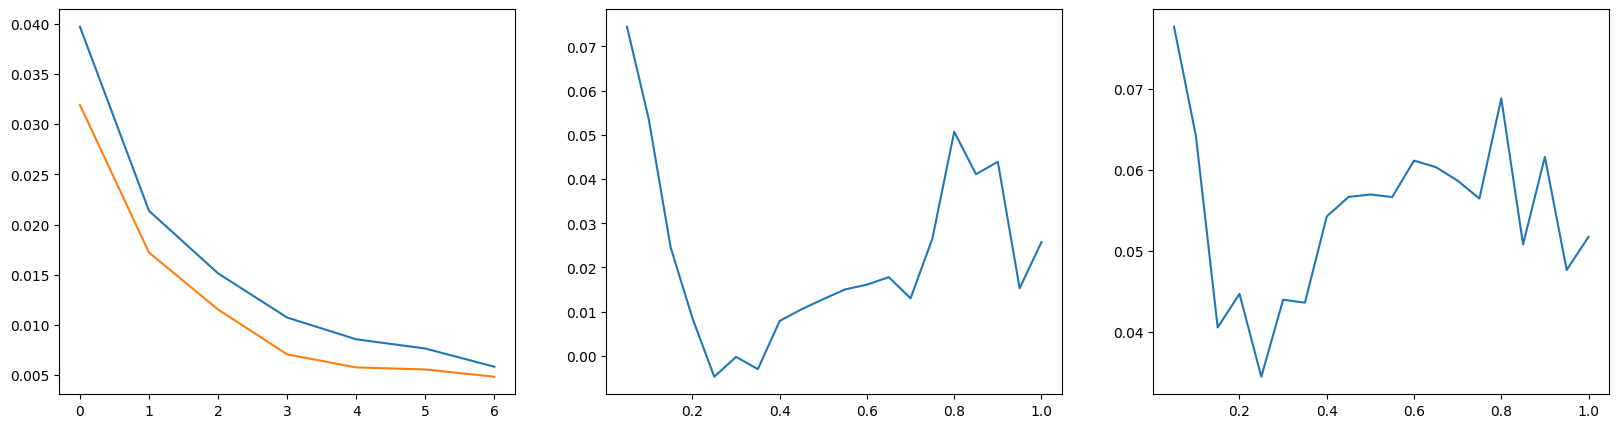

Epoch 8
-------------------------------

k-1
Avg diff: 0.056332, Avg loss: 0.004687, Min rate: 0.023716, Max rate: 1.031610  [  800/ 3630]
Avg diff: 0.054516, Avg loss: 0.004532, Min rate: 0.014378, Max rate: 1.089634  [ 1600/ 3630]
Avg diff: 0.055416, Avg loss: 0.004774, Min rate: -0.063948, Max rate: 1.042845  [ 2400/ 3630]
Avg diff: 0.055369, Avg loss: 0.004838, Min rate: 0.036154, Max rate: 1.032504  [ 3200/ 3630]
Avg diff: 0.059762, Avg loss: 0.005818, Min rate: 0.007027, Max rate: 1.039102  [ 3630/ 3630]


100%|██████████| 114/114 [00:14<00:00,  7.66it/s]



k-2
Avg diff: 0.056384, Avg loss: 0.005121, Min rate: -0.058746, Max rate: 1.054266  [  800/ 3630]
Avg diff: 0.053467, Avg loss: 0.004701, Min rate: -0.017997, Max rate: 1.038942  [ 1600/ 3630]
Avg diff: 0.052935, Avg loss: 0.004376, Min rate: -0.019825, Max rate: 1.043591  [ 2400/ 3630]
Avg diff: 0.052390, Avg loss: 0.004542, Min rate: -0.013547, Max rate: 1.067884  [ 3200/ 3630]
Avg diff: 0.059173, Avg loss: 0.005734, Min rate: 0.009181, Max rate: 1.018623  [ 3630/ 3630]


100%|██████████| 114/114 [00:14<00:00,  7.78it/s]



k-3
Avg diff: 0.051317, Avg loss: 0.004146, Min rate: 0.013890, Max rate: 1.054319  [  800/ 3630]
Avg diff: 0.052692, Avg loss: 0.004749, Min rate: -0.002327, Max rate: 1.021293  [ 1600/ 3630]
Avg diff: 0.055944, Avg loss: 0.005276, Min rate: 0.012038, Max rate: 1.011590  [ 2400/ 3630]
Avg diff: 0.058472, Avg loss: 0.005434, Min rate: 0.013322, Max rate: 1.043604  [ 3200/ 3630]
Avg diff: 0.057189, Avg loss: 0.005585, Min rate: 0.035203, Max rate: 1.078882  [ 3630/ 3630]


100%|██████████| 114/114 [00:16<00:00,  7.08it/s]



k-4
Avg diff: 0.051837, Avg loss: 0.004418, Min rate: -0.010324, Max rate: 1.140316  [  800/ 3630]
Avg diff: 0.053496, Avg loss: 0.004755, Min rate: -0.019214, Max rate: 1.033375  [ 1600/ 3630]
Avg diff: 0.054217, Avg loss: 0.005007, Min rate: -0.021882, Max rate: 1.031430  [ 2400/ 3630]
Avg diff: 0.058440, Avg loss: 0.005503, Min rate: -0.030109, Max rate: 1.055214  [ 3200/ 3630]
Avg diff: 0.059474, Avg loss: 0.005845, Min rate: -0.014477, Max rate: 1.007067  [ 3630/ 3630]


100%|██████████| 114/114 [00:18<00:00,  6.08it/s]



k-5
Avg diff: 0.053354, Avg loss: 0.004659, Min rate: -0.001724, Max rate: 1.022891  [  800/ 3628]
Avg diff: 0.051389, Avg loss: 0.004370, Min rate: -0.028535, Max rate: 1.033427  [ 1600/ 3628]
Avg diff: 0.057857, Avg loss: 0.005700, Min rate: 0.009314, Max rate: 1.040837  [ 2400/ 3628]
Avg diff: 0.057657, Avg loss: 0.005622, Min rate: -0.059278, Max rate: 1.104582  [ 3200/ 3628]
Avg diff: 0.059598, Avg loss: 0.006065, Min rate: 0.020863, Max rate: 1.013130  [ 3628/ 3628]


100%|██████████| 114/114 [00:16<00:00,  6.91it/s]
C:\Users\yrasi\AppData\Local\Temp\ipykernel_4104\2076441446.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('range', as_index=False).mean()


Test Results: 
 Accuracy: 0.101851, Avg loss: 0.004091, Min rate: 0.000388, Max rate: 1.073773, Max diff 0.319270


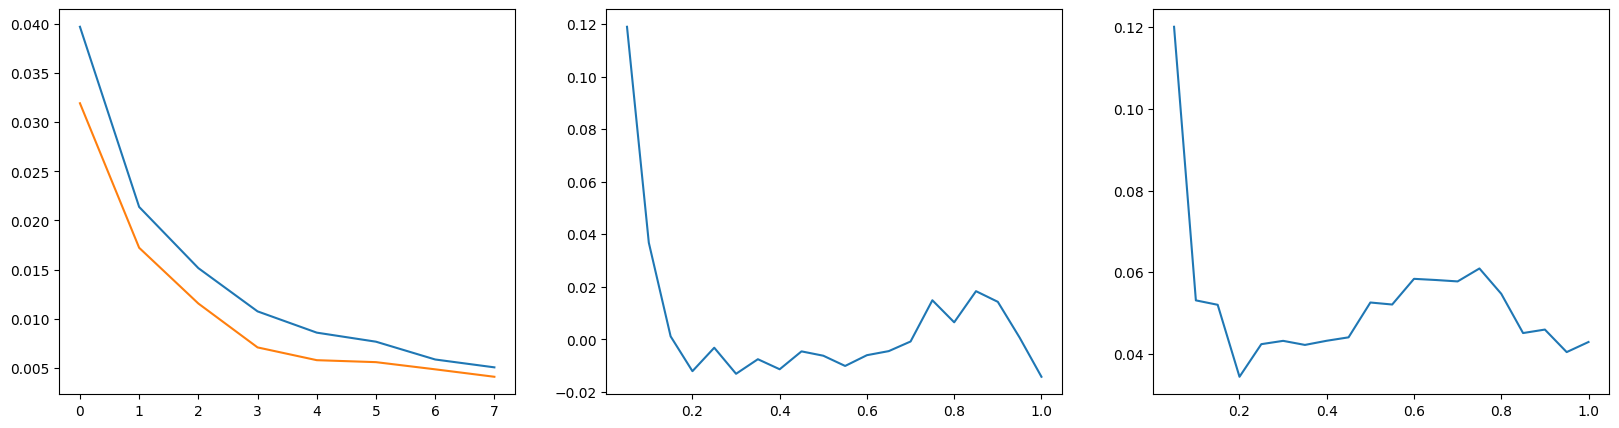

Epoch 9
-------------------------------

k-1
Avg diff: 0.053139, Avg loss: 0.004482, Min rate: 0.030402, Max rate: 1.017966  [  800/ 3630]
Avg diff: 0.056520, Avg loss: 0.004713, Min rate: 0.018158, Max rate: 1.070505  [ 1600/ 3630]
Avg diff: 0.054061, Avg loss: 0.004162, Min rate: -0.005712, Max rate: 1.059527  [ 2400/ 3630]
Avg diff: 0.053330, Avg loss: 0.004512, Min rate: 0.019250, Max rate: 1.046685  [ 3200/ 3630]
Avg diff: 0.051386, Avg loss: 0.004141, Min rate: -0.021979, Max rate: 1.081692  [ 3630/ 3630]


100%|██████████| 114/114 [00:15<00:00,  7.32it/s]



k-2
Avg diff: 0.049273, Avg loss: 0.003790, Min rate: 0.004792, Max rate: 1.002222  [  800/ 3630]
Avg diff: 0.054869, Avg loss: 0.004989, Min rate: -0.032854, Max rate: 1.030427  [ 1600/ 3630]
Avg diff: 0.053173, Avg loss: 0.004380, Min rate: 0.003445, Max rate: 1.029369  [ 2400/ 3630]
Avg diff: 0.054495, Avg loss: 0.004623, Min rate: -0.050842, Max rate: 1.085046  [ 3200/ 3630]
Avg diff: 0.063179, Avg loss: 0.009892, Min rate: -0.012783, Max rate: 1.039018  [ 3630/ 3630]


100%|██████████| 114/114 [00:15<00:00,  7.51it/s]



k-3
Avg diff: 0.049524, Avg loss: 0.003743, Min rate: 0.005565, Max rate: 1.049878  [  800/ 3630]
Avg diff: 0.051654, Avg loss: 0.004452, Min rate: 0.022332, Max rate: 1.054967  [ 1600/ 3630]
Avg diff: 0.058520, Avg loss: 0.005952, Min rate: -0.026514, Max rate: 1.106656  [ 2400/ 3630]
Avg diff: 0.053565, Avg loss: 0.004374, Min rate: -0.076531, Max rate: 1.056328  [ 3200/ 3630]
Avg diff: 0.057258, Avg loss: 0.005077, Min rate: -0.013036, Max rate: 0.990623  [ 3630/ 3630]


100%|██████████| 114/114 [00:15<00:00,  7.35it/s]



k-4
Avg diff: 0.068446, Avg loss: 0.010475, Min rate: 0.013645, Max rate: 1.099376  [  800/ 3630]
Avg diff: 0.074235, Avg loss: 0.009906, Min rate: -0.000901, Max rate: 1.047577  [ 1600/ 3630]
Avg diff: 0.067368, Avg loss: 0.007934, Min rate: -0.020978, Max rate: 1.064181  [ 2400/ 3630]
Avg diff: 0.062998, Avg loss: 0.007396, Min rate: -0.097504, Max rate: 1.085367  [ 3200/ 3630]
Avg diff: 0.063986, Avg loss: 0.007534, Min rate: 0.010857, Max rate: 0.991867  [ 3630/ 3630]


100%|██████████| 114/114 [00:17<00:00,  6.60it/s]



k-5
Avg diff: 0.060854, Avg loss: 0.006612, Min rate: -0.027802, Max rate: 1.060853  [  800/ 3628]
Avg diff: 0.060184, Avg loss: 0.005841, Min rate: 0.005186, Max rate: 1.059359  [ 1600/ 3628]
Avg diff: 0.053952, Avg loss: 0.004965, Min rate: -0.046860, Max rate: 1.049517  [ 2400/ 3628]
Avg diff: 0.054068, Avg loss: 0.004868, Min rate: -0.003095, Max rate: 1.056448  [ 3200/ 3628]
Avg diff: 0.054334, Avg loss: 0.004696, Min rate: -0.025402, Max rate: 1.053286  [ 3628/ 3628]


100%|██████████| 114/114 [00:16<00:00,  6.77it/s]
C:\Users\yrasi\AppData\Local\Temp\ipykernel_4104\2076441446.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('range', as_index=False).mean()


Test Results: 
 Accuracy: 0.098761, Avg loss: 0.003851, Min rate: -0.094207, Max rate: 1.077657, Max diff 0.336317


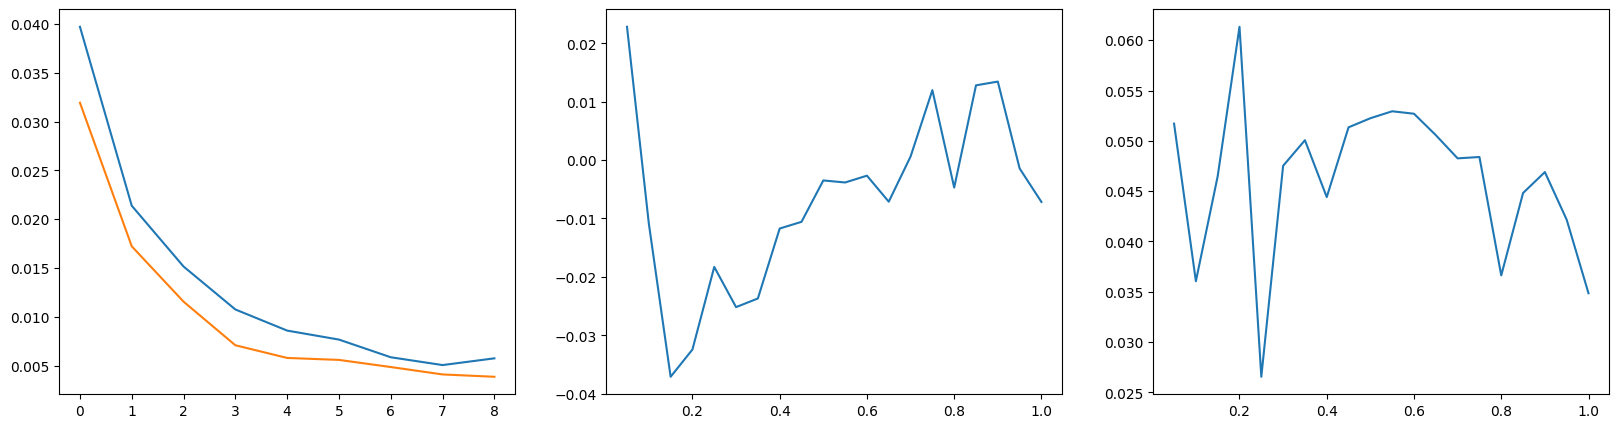

Epoch 10
-------------------------------

k-1
Avg diff: 0.051636, Avg loss: 0.003956, Min rate: 0.033354, Max rate: 1.071808  [  800/ 3630]
Avg diff: 0.047802, Avg loss: 0.003527, Min rate: 0.035376, Max rate: 1.046144  [ 1600/ 3630]
Avg diff: 0.045566, Avg loss: 0.003400, Min rate: -0.005101, Max rate: 1.052089  [ 2400/ 3630]
Avg diff: 0.051075, Avg loss: 0.003825, Min rate: 0.010974, Max rate: 1.046233  [ 3200/ 3630]
Avg diff: 0.050958, Avg loss: 0.003689, Min rate: 0.064024, Max rate: 1.051335  [ 3630/ 3630]


100%|██████████| 114/114 [00:15<00:00,  7.16it/s]



k-2
Avg diff: 0.048952, Avg loss: 0.004271, Min rate: 0.001498, Max rate: 1.024953  [  800/ 3630]
Avg diff: 0.079937, Avg loss: 0.013781, Min rate: 0.001603, Max rate: 1.071531  [ 1600/ 3630]
Avg diff: 0.069115, Avg loss: 0.008179, Min rate: 0.042579, Max rate: 0.998835  [ 2400/ 3630]
Avg diff: 0.061937, Avg loss: 0.006396, Min rate: 0.018154, Max rate: 1.099775  [ 3200/ 3630]
Avg diff: 0.063316, Avg loss: 0.005974, Min rate: 0.025277, Max rate: 1.002201  [ 3630/ 3630]


100%|██████████| 114/114 [00:15<00:00,  7.55it/s]



k-3
Avg diff: 0.057529, Avg loss: 0.005460, Min rate: -0.002261, Max rate: 1.035109  [  800/ 3630]
Avg diff: 0.059388, Avg loss: 0.007124, Min rate: -0.042601, Max rate: 1.044682  [ 1600/ 3630]
Avg diff: 0.057646, Avg loss: 0.006140, Min rate: 0.034664, Max rate: 1.028004  [ 2400/ 3630]
Avg diff: 0.058837, Avg loss: 0.006019, Min rate: 0.025396, Max rate: 1.023466  [ 3200/ 3630]
Avg diff: 0.060306, Avg loss: 0.006552, Min rate: -0.004783, Max rate: 1.028752  [ 3630/ 3630]


100%|██████████| 114/114 [00:16<00:00,  7.11it/s]



k-4
Avg diff: 0.052549, Avg loss: 0.004601, Min rate: 0.007789, Max rate: 1.041869  [  800/ 3630]
Avg diff: 0.064916, Avg loss: 0.008034, Min rate: 0.004272, Max rate: 1.071126  [ 1600/ 3630]
Avg diff: 0.055352, Avg loss: 0.005382, Min rate: -0.003402, Max rate: 1.039701  [ 2400/ 3630]
Avg diff: 0.058268, Avg loss: 0.006275, Min rate: -0.028608, Max rate: 1.042750  [ 3200/ 3630]
Avg diff: 0.053491, Avg loss: 0.005253, Min rate: -0.007180, Max rate: 1.000115  [ 3630/ 3630]


100%|██████████| 114/114 [00:16<00:00,  6.73it/s]



k-5
Avg diff: 0.056612, Avg loss: 0.005188, Min rate: 0.032297, Max rate: 1.047914  [  800/ 3628]
Avg diff: 0.053507, Avg loss: 0.004711, Min rate: -0.017548, Max rate: 1.025096  [ 1600/ 3628]
Avg diff: 0.051819, Avg loss: 0.004771, Min rate: -0.020360, Max rate: 1.040615  [ 2400/ 3628]
Avg diff: 0.049593, Avg loss: 0.004051, Min rate: -0.008001, Max rate: 1.029652  [ 3200/ 3628]
Avg diff: 0.053546, Avg loss: 0.004802, Min rate: -0.001904, Max rate: 1.068200  [ 3628/ 3628]


100%|██████████| 114/114 [00:16<00:00,  6.99it/s]
C:\Users\yrasi\AppData\Local\Temp\ipykernel_4104\2076441446.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('range', as_index=False).mean()


Test Results: 
 Accuracy: 0.090176, Avg loss: 0.003228, Min rate: -0.035757, Max rate: 1.063972, Max diff 0.293465


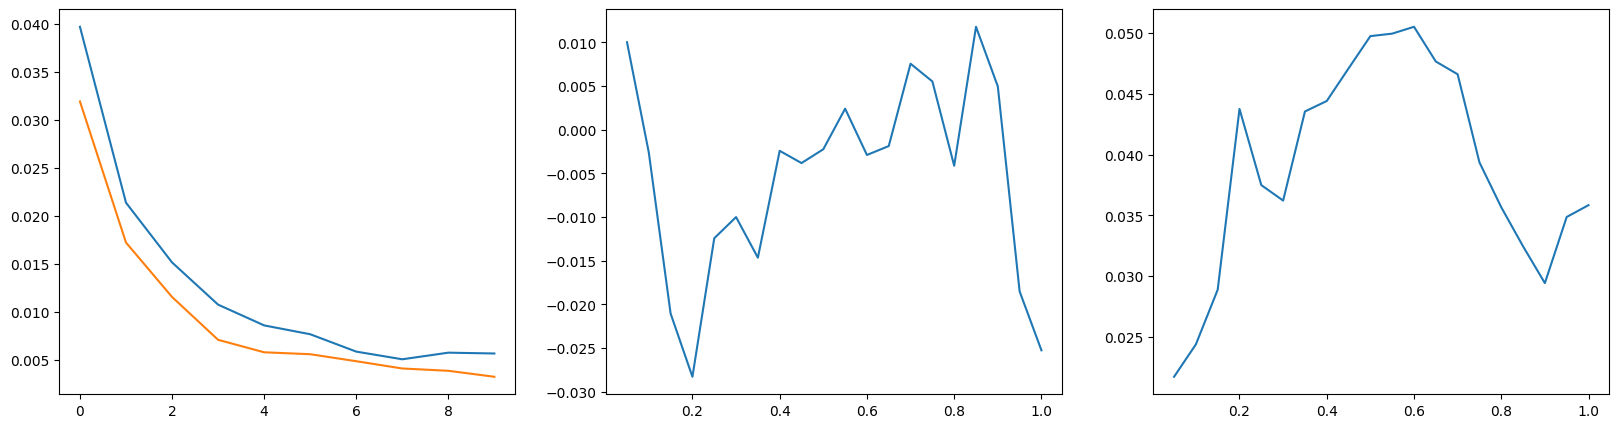

Epoch 11
-------------------------------

k-1
Avg diff: 0.047157, Avg loss: 0.003302, Min rate: 0.035363, Max rate: 1.034708  [  800/ 3630]
Avg diff: 0.044346, Avg loss: 0.003086, Min rate: 0.005672, Max rate: 1.051777  [ 1600/ 3630]
Avg diff: 0.046805, Avg loss: 0.003408, Min rate: 0.011835, Max rate: 1.018028  [ 2400/ 3630]
Avg diff: 0.044399, Avg loss: 0.003013, Min rate: 0.054614, Max rate: 1.020085  [ 3200/ 3630]
Avg diff: 0.046673, Avg loss: 0.003348, Min rate: 0.002298, Max rate: 0.996377  [ 3630/ 3630]


100%|██████████| 114/114 [00:15<00:00,  7.34it/s]



k-2
Avg diff: 0.045657, Avg loss: 0.003304, Min rate: 0.011276, Max rate: 1.058431  [  800/ 3630]
Avg diff: 0.047561, Avg loss: 0.003676, Min rate: 0.016541, Max rate: 1.040192  [ 1600/ 3630]
Avg diff: 0.045982, Avg loss: 0.003372, Min rate: -0.007642, Max rate: 1.052184  [ 2400/ 3630]
Avg diff: 0.048583, Avg loss: 0.003760, Min rate: 0.009451, Max rate: 1.048612  [ 3200/ 3630]
Avg diff: 0.050420, Avg loss: 0.004424, Min rate: 0.035889, Max rate: 1.034078  [ 3630/ 3630]


100%|██████████| 114/114 [00:14<00:00,  7.60it/s]



k-3
Avg diff: 0.042662, Avg loss: 0.002891, Min rate: 0.002968, Max rate: 1.012424  [  800/ 3630]
Avg diff: 0.046189, Avg loss: 0.003148, Min rate: 0.004073, Max rate: 1.025901  [ 1600/ 3630]
Avg diff: 0.044260, Avg loss: 0.003037, Min rate: -0.088706, Max rate: 1.042429  [ 2400/ 3630]
Avg diff: 0.042023, Avg loss: 0.002905, Min rate: -0.008897, Max rate: 1.053216  [ 3200/ 3630]
Avg diff: 0.050357, Avg loss: 0.004114, Min rate: 0.013599, Max rate: 1.016326  [ 3630/ 3630]


100%|██████████| 114/114 [00:16<00:00,  7.01it/s]



k-4
Avg diff: 0.047998, Avg loss: 0.004088, Min rate: -0.004176, Max rate: 1.058596  [  800/ 3630]
Avg diff: 0.049987, Avg loss: 0.003920, Min rate: 0.007864, Max rate: 1.026852  [ 1600/ 3630]
Avg diff: 0.045920, Avg loss: 0.003474, Min rate: 0.011049, Max rate: 1.095550  [ 2400/ 3630]
Avg diff: 0.044523, Avg loss: 0.003361, Min rate: -0.026012, Max rate: 1.061185  [ 3200/ 3630]
Avg diff: 0.044130, Avg loss: 0.003315, Min rate: -0.003244, Max rate: 1.039755  [ 3630/ 3630]


100%|██████████| 114/114 [00:16<00:00,  6.80it/s]



k-5
Avg diff: 0.046928, Avg loss: 0.003685, Min rate: -0.030312, Max rate: 1.022791  [  800/ 3628]
Avg diff: 0.045747, Avg loss: 0.003597, Min rate: 0.014059, Max rate: 1.063738  [ 1600/ 3628]
Avg diff: 0.044015, Avg loss: 0.002992, Min rate: -0.017731, Max rate: 1.044443  [ 2400/ 3628]
Avg diff: 0.047337, Avg loss: 0.003506, Min rate: 0.017195, Max rate: 1.049365  [ 3200/ 3628]
Avg diff: 0.047472, Avg loss: 0.003468, Min rate: -0.014699, Max rate: 1.008763  [ 3628/ 3628]


100%|██████████| 114/114 [00:16<00:00,  6.83it/s]
C:\Users\yrasi\AppData\Local\Temp\ipykernel_4104\2076441446.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('range', as_index=False).mean()


Test Results: 
 Accuracy: 0.079169, Avg loss: 0.002406, Min rate: 0.001084, Max rate: 1.096819, Max diff 0.238854


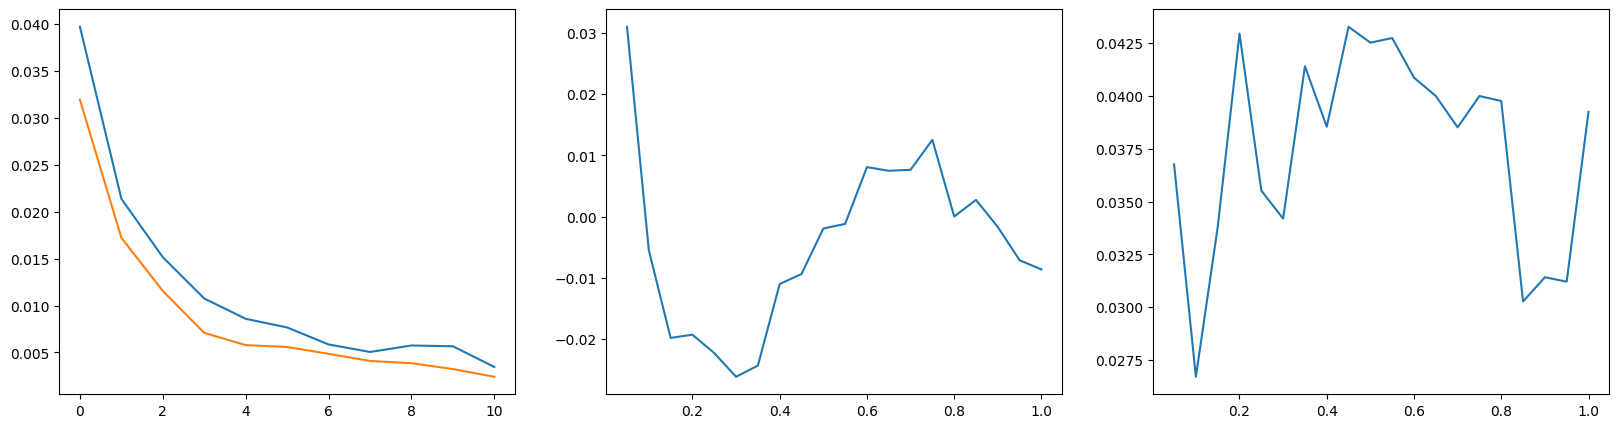

Epoch 12
-------------------------------

k-1
Avg diff: 0.043069, Avg loss: 0.002911, Min rate: 0.035591, Max rate: 1.009952  [  800/ 3630]
Avg diff: 0.058097, Avg loss: 0.005882, Min rate: -0.011989, Max rate: 1.066024  [ 1600/ 3630]
Avg diff: 0.055608, Avg loss: 0.005221, Min rate: -0.010593, Max rate: 1.079570  [ 2400/ 3630]
Avg diff: 0.049388, Avg loss: 0.003685, Min rate: -0.009587, Max rate: 1.040983  [ 3200/ 3630]
Avg diff: 0.053217, Avg loss: 0.004641, Min rate: 0.029069, Max rate: 1.042901  [ 3630/ 3630]


100%|██████████| 114/114 [00:16<00:00,  6.93it/s]



k-2
Avg diff: 0.052063, Avg loss: 0.004370, Min rate: -0.006169, Max rate: 1.075297  [  800/ 3630]
Avg diff: 0.046212, Avg loss: 0.003242, Min rate: 0.021663, Max rate: 1.041813  [ 1600/ 3630]
Avg diff: 0.047103, Avg loss: 0.003261, Min rate: 0.012792, Max rate: 1.063178  [ 2400/ 3630]
Avg diff: 0.045952, Avg loss: 0.003330, Min rate: -0.069772, Max rate: 1.019501  [ 3200/ 3630]
Avg diff: 0.046841, Avg loss: 0.003575, Min rate: 0.020330, Max rate: 1.125757  [ 3630/ 3630]


100%|██████████| 114/114 [00:15<00:00,  7.39it/s]



k-3
Avg diff: 0.049713, Avg loss: 0.004124, Min rate: -0.024283, Max rate: 1.042980  [  800/ 3630]
Avg diff: 0.046275, Avg loss: 0.003285, Min rate: 0.037938, Max rate: 1.016687  [ 1600/ 3630]
Avg diff: 0.044858, Avg loss: 0.003224, Min rate: -0.002245, Max rate: 1.013294  [ 2400/ 3630]
Avg diff: 0.056542, Avg loss: 0.006586, Min rate: -0.013571, Max rate: 1.043306  [ 3200/ 3630]
Avg diff: 0.052948, Avg loss: 0.004478, Min rate: -0.005793, Max rate: 1.086082  [ 3630/ 3630]


100%|██████████| 114/114 [00:15<00:00,  7.57it/s]



k-4
Avg diff: 0.052875, Avg loss: 0.004917, Min rate: 0.018844, Max rate: 1.011402  [  800/ 3630]
Avg diff: 0.049126, Avg loss: 0.004094, Min rate: 0.015418, Max rate: 1.043165  [ 1600/ 3630]
Avg diff: 0.048713, Avg loss: 0.003879, Min rate: -0.026898, Max rate: 1.074439  [ 2400/ 3630]
Avg diff: 0.048285, Avg loss: 0.003947, Min rate: -0.062611, Max rate: 1.057501  [ 3200/ 3630]
Avg diff: 0.047232, Avg loss: 0.003721, Min rate: 0.027494, Max rate: 1.061785  [ 3630/ 3630]


100%|██████████| 114/114 [00:18<00:00,  6.06it/s]



k-5
Avg diff: 0.047091, Avg loss: 0.003708, Min rate: 0.000633, Max rate: 1.092743  [  800/ 3628]
Avg diff: 0.043625, Avg loss: 0.003093, Min rate: 0.017184, Max rate: 1.067313  [ 1600/ 3628]
Avg diff: 0.046871, Avg loss: 0.003703, Min rate: -0.012386, Max rate: 1.043707  [ 2400/ 3628]
Avg diff: 0.047639, Avg loss: 0.003442, Min rate: 0.003066, Max rate: 1.001453  [ 3200/ 3628]
Avg diff: 0.044768, Avg loss: 0.003436, Min rate: -0.014235, Max rate: 1.062678  [ 3628/ 3628]


100%|██████████| 114/114 [00:19<00:00,  5.78it/s]
C:\Users\yrasi\AppData\Local\Temp\ipykernel_4104\2076441446.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('range', as_index=False).mean()


Test Results: 
 Accuracy: 0.089792, Avg loss: 0.003076, Min rate: -0.023801, Max rate: 1.085088, Max diff 0.310925


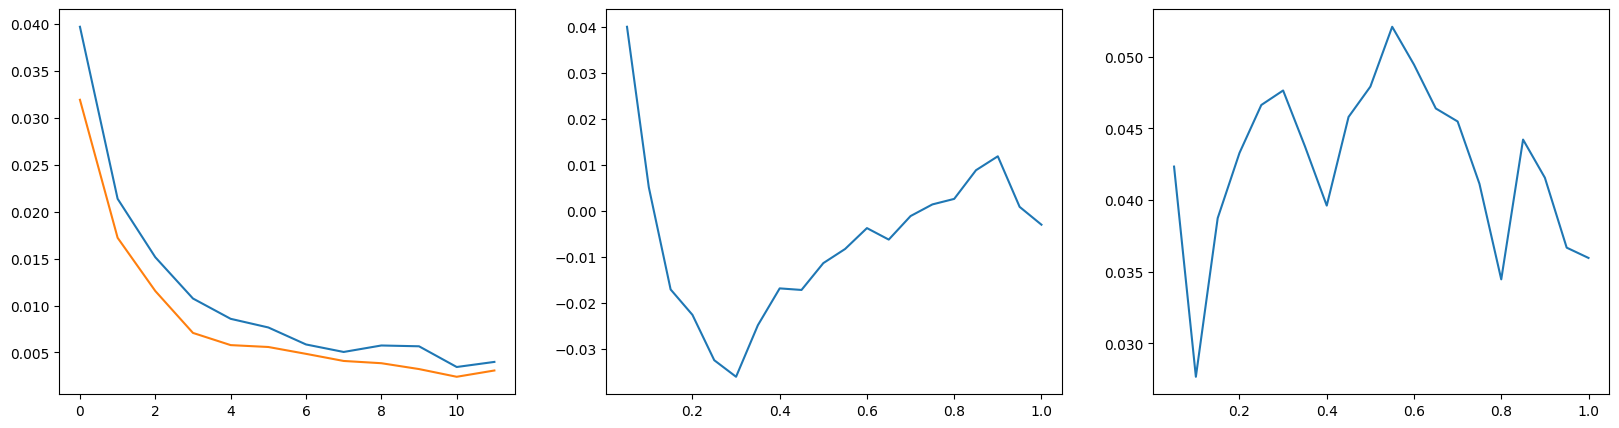

Epoch 13
-------------------------------

k-1
Avg diff: 0.044912, Avg loss: 0.002959, Min rate: 0.033661, Max rate: 1.060976  [  800/ 3630]
Avg diff: 0.042391, Avg loss: 0.002715, Min rate: -0.024093, Max rate: 1.018942  [ 1600/ 3630]
Avg diff: 0.044681, Avg loss: 0.003124, Min rate: 0.001640, Max rate: 1.074689  [ 2400/ 3630]
Avg diff: 0.041447, Avg loss: 0.002720, Min rate: -0.015594, Max rate: 1.020594  [ 3200/ 3630]
Avg diff: 0.043220, Avg loss: 0.002699, Min rate: 0.080314, Max rate: 0.953858  [ 3630/ 3630]


100%|██████████| 114/114 [00:16<00:00,  7.04it/s]



k-2
Avg diff: 0.040042, Avg loss: 0.002467, Min rate: 0.003035, Max rate: 1.032410  [  800/ 3630]
Avg diff: 0.040608, Avg loss: 0.002671, Min rate: -0.081157, Max rate: 1.046739  [ 1600/ 3630]
Avg diff: 0.044964, Avg loss: 0.003048, Min rate: 0.001889, Max rate: 1.048290  [ 2400/ 3630]
Avg diff: 0.049998, Avg loss: 0.004183, Min rate: -0.024599, Max rate: 1.101318  [ 3200/ 3630]
Avg diff: 0.047713, Avg loss: 0.003480, Min rate: 0.058812, Max rate: 1.016342  [ 3630/ 3630]


100%|██████████| 114/114 [00:14<00:00,  7.84it/s]



k-3
Avg diff: 0.048825, Avg loss: 0.003923, Min rate: -0.043595, Max rate: 1.011699  [  800/ 3630]
Avg diff: 0.045353, Avg loss: 0.003256, Min rate: 0.031542, Max rate: 1.050439  [ 1600/ 3630]
Avg diff: 0.046452, Avg loss: 0.003585, Min rate: -0.029632, Max rate: 1.053120  [ 2400/ 3630]
Avg diff: 0.045485, Avg loss: 0.003514, Min rate: -0.015214, Max rate: 1.053395  [ 3200/ 3630]
Avg diff: 0.047794, Avg loss: 0.003879, Min rate: 0.009338, Max rate: 0.997827  [ 3630/ 3630]


100%|██████████| 114/114 [00:14<00:00,  7.62it/s]



k-4
Avg diff: 0.047212, Avg loss: 0.003903, Min rate: -0.050435, Max rate: 1.086401  [  800/ 3630]
Avg diff: 0.047200, Avg loss: 0.003884, Min rate: 0.024633, Max rate: 1.049216  [ 1600/ 3630]
Avg diff: 0.046822, Avg loss: 0.003670, Min rate: -0.023218, Max rate: 1.019595  [ 2400/ 3630]
Avg diff: 0.043071, Avg loss: 0.003082, Min rate: -0.004392, Max rate: 1.045629  [ 3200/ 3630]
Avg diff: 0.042496, Avg loss: 0.002798, Min rate: -0.010455, Max rate: 1.022752  [ 3630/ 3630]


100%|██████████| 114/114 [00:14<00:00,  7.73it/s]



k-5
Avg diff: 0.041046, Avg loss: 0.002737, Min rate: -0.000349, Max rate: 1.062833  [  800/ 3628]
Avg diff: 0.042260, Avg loss: 0.002866, Min rate: -0.029133, Max rate: 1.041502  [ 1600/ 3628]
Avg diff: 0.045582, Avg loss: 0.004027, Min rate: -0.006190, Max rate: 1.026505  [ 2400/ 3628]
Avg diff: 0.042618, Avg loss: 0.003020, Min rate: -0.007600, Max rate: 1.041602  [ 3200/ 3628]
Avg diff: 0.042701, Avg loss: 0.003108, Min rate: 0.010028, Max rate: 1.106893  [ 3628/ 3628]


100%|██████████| 114/114 [00:15<00:00,  7.33it/s]
C:\Users\yrasi\AppData\Local\Temp\ipykernel_4104\2076441446.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('range', as_index=False).mean()


Test Results: 
 Accuracy: 0.079582, Avg loss: 0.002514, Min rate: -0.022991, Max rate: 1.082717, Max diff 0.253929


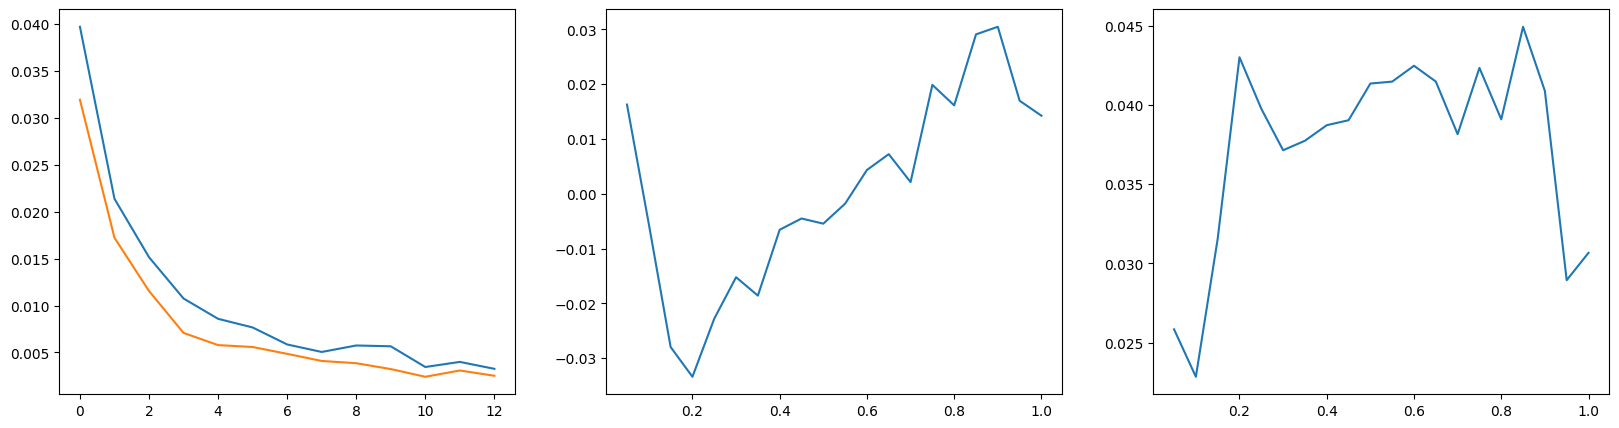

Epoch 14
-------------------------------

k-1
Avg diff: 0.041644, Avg loss: 0.002410, Min rate: 0.037389, Max rate: 1.014487  [  800/ 3630]
Avg diff: 0.041626, Avg loss: 0.002661, Min rate: 0.026852, Max rate: 1.006956  [ 1600/ 3630]
Avg diff: 0.040868, Avg loss: 0.002650, Min rate: 0.011635, Max rate: 0.995493  [ 2400/ 3630]
Avg diff: 0.043413, Avg loss: 0.002889, Min rate: -0.045491, Max rate: 1.032862  [ 3200/ 3630]
Avg diff: 0.044347, Avg loss: 0.003122, Min rate: 0.034050, Max rate: 1.020506  [ 3630/ 3630]


100%|██████████| 114/114 [00:21<00:00,  5.40it/s]



k-2
Avg diff: 0.047899, Avg loss: 0.004213, Min rate: 0.005821, Max rate: 1.035189  [  800/ 3630]
Avg diff: 0.059546, Avg loss: 0.007384, Min rate: 0.052515, Max rate: 0.986987  [ 1600/ 3630]
Avg diff: 0.056482, Avg loss: 0.007316, Min rate: 0.021314, Max rate: 1.044833  [ 2400/ 3630]
Avg diff: 0.064204, Avg loss: 0.007327, Min rate: -0.065745, Max rate: 1.226242  [ 3200/ 3630]
Avg diff: 0.075882, Avg loss: 0.011623, Min rate: -0.021493, Max rate: 1.059572  [ 3630/ 3630]


100%|██████████| 114/114 [00:14<00:00,  8.00it/s]



k-3
Avg diff: 0.062986, Avg loss: 0.007153, Min rate: 0.006562, Max rate: 1.065162  [  800/ 3630]
Avg diff: 0.072560, Avg loss: 0.011971, Min rate: -0.007740, Max rate: 1.060473  [ 1600/ 3630]
Avg diff: 0.062947, Avg loss: 0.007008, Min rate: -0.006518, Max rate: 1.098967  [ 2400/ 3630]
Avg diff: 0.053173, Avg loss: 0.004479, Min rate: -0.061266, Max rate: 1.037569  [ 3200/ 3630]
Avg diff: 0.049310, Avg loss: 0.003612, Min rate: -0.012029, Max rate: 1.008625  [ 3630/ 3630]


100%|██████████| 114/114 [00:20<00:00,  5.46it/s]



k-4
Avg diff: 0.049993, Avg loss: 0.003949, Min rate: -0.011467, Max rate: 1.061588  [  800/ 3630]
Avg diff: 0.049616, Avg loss: 0.004107, Min rate: -0.009514, Max rate: 1.067893  [ 1600/ 3630]
Avg diff: 0.049054, Avg loss: 0.004983, Min rate: -0.040381, Max rate: 1.020507  [ 2400/ 3630]
Avg diff: 0.057245, Avg loss: 0.006901, Min rate: 0.011221, Max rate: 1.041385  [ 3200/ 3630]
Avg diff: 0.053798, Avg loss: 0.005455, Min rate: -0.018003, Max rate: 1.007317  [ 3630/ 3630]


100%|██████████| 114/114 [00:16<00:00,  7.08it/s]



k-5
Avg diff: 0.057718, Avg loss: 0.006028, Min rate: -0.036418, Max rate: 1.047337  [  800/ 3628]
Avg diff: 0.052904, Avg loss: 0.004632, Min rate: -0.002982, Max rate: 1.045720  [ 1600/ 3628]
Avg diff: 0.046059, Avg loss: 0.003583, Min rate: -0.083875, Max rate: 1.044924  [ 2400/ 3628]
Avg diff: 0.046886, Avg loss: 0.003645, Min rate: 0.010686, Max rate: 1.056942  [ 3200/ 3628]
Avg diff: 0.048927, Avg loss: 0.004109, Min rate: 0.024971, Max rate: 1.025043  [ 3628/ 3628]


100%|██████████| 114/114 [00:15<00:00,  7.45it/s]
C:\Users\yrasi\AppData\Local\Temp\ipykernel_4104\2076441446.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('range', as_index=False).mean()


Test Results: 
 Accuracy: 0.093853, Avg loss: 0.003731, Min rate: -0.077520, Max rate: 1.057473, Max diff 0.807452


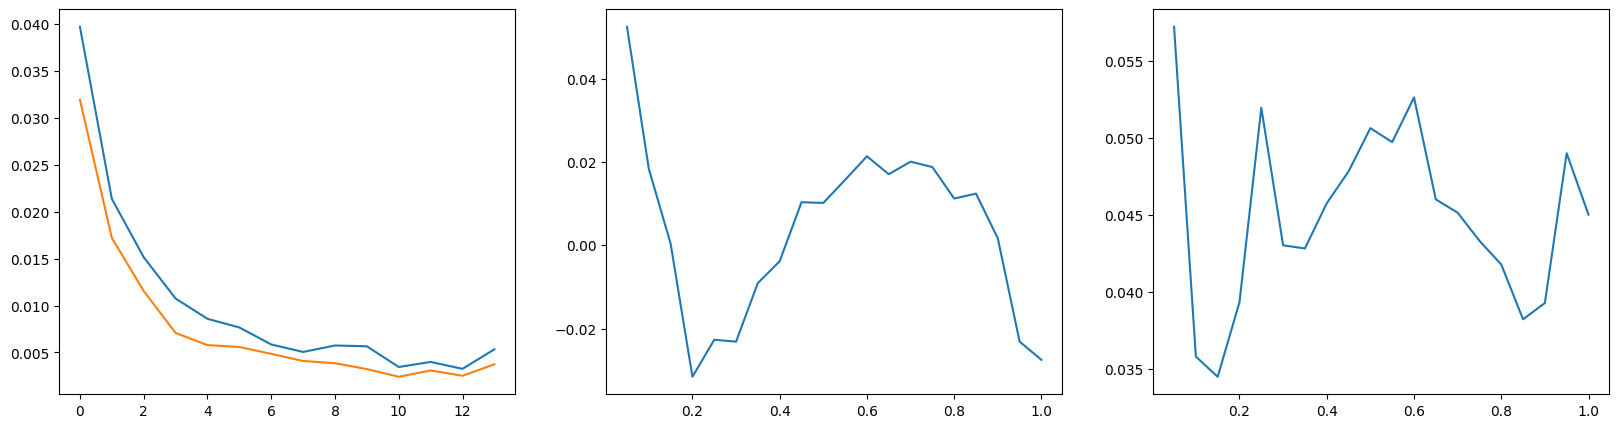

Epoch 15
-------------------------------

k-1
Avg diff: 0.043697, Avg loss: 0.002706, Min rate: 0.034664, Max rate: 1.010377  [  800/ 3630]
Avg diff: 0.041820, Avg loss: 0.002562, Min rate: 0.019839, Max rate: 1.008143  [ 1600/ 3630]
Avg diff: 0.045026, Avg loss: 0.003188, Min rate: 0.015355, Max rate: 1.019349  [ 2400/ 3630]
Avg diff: 0.041766, Avg loss: 0.002865, Min rate: 0.026796, Max rate: 1.028855  [ 3200/ 3630]
Avg diff: 0.041997, Avg loss: 0.002784, Min rate: 0.017782, Max rate: 1.023089  [ 3630/ 3630]


100%|██████████| 114/114 [00:14<00:00,  8.07it/s]



k-2
Avg diff: 0.040692, Avg loss: 0.002751, Min rate: 0.022669, Max rate: 1.055279  [  800/ 3630]
Avg diff: 0.042217, Avg loss: 0.002911, Min rate: 0.044879, Max rate: 1.043138  [ 1600/ 3630]
Avg diff: 0.040134, Avg loss: 0.002573, Min rate: -0.004330, Max rate: 1.031265  [ 2400/ 3630]
Avg diff: 0.040636, Avg loss: 0.002524, Min rate: 0.010440, Max rate: 0.996841  [ 3200/ 3630]
Avg diff: 0.041331, Avg loss: 0.003640, Min rate: 0.006738, Max rate: 1.001937  [ 3630/ 3630]


100%|██████████| 114/114 [00:14<00:00,  7.89it/s]



k-3
Avg diff: 0.046547, Avg loss: 0.003679, Min rate: -0.009209, Max rate: 1.032572  [  800/ 3630]
Avg diff: 0.044743, Avg loss: 0.003209, Min rate: -0.005784, Max rate: 0.999045  [ 1600/ 3630]
Avg diff: 0.044073, Avg loss: 0.003198, Min rate: 0.010004, Max rate: 1.041349  [ 2400/ 3630]
Avg diff: 0.043615, Avg loss: 0.002983, Min rate: 0.008986, Max rate: 1.019394  [ 3200/ 3630]
Avg diff: 0.044626, Avg loss: 0.003096, Min rate: 0.019393, Max rate: 1.047882  [ 3630/ 3630]


100%|██████████| 114/114 [00:14<00:00,  7.66it/s]



k-4
Avg diff: 0.050974, Avg loss: 0.006026, Min rate: -0.006131, Max rate: 1.088409  [  800/ 3630]
Avg diff: 0.072719, Avg loss: 0.012007, Min rate: -0.049263, Max rate: 1.106274  [ 1600/ 3630]
Avg diff: 0.064551, Avg loss: 0.006654, Min rate: -0.024090, Max rate: 1.107798  [ 2400/ 3630]
Avg diff: 0.059574, Avg loss: 0.006680, Min rate: -0.014294, Max rate: 1.032248  [ 3200/ 3630]
Avg diff: 0.053147, Avg loss: 0.004944, Min rate: 0.061483, Max rate: 1.041835  [ 3630/ 3630]


100%|██████████| 114/114 [00:17<00:00,  6.56it/s]



k-5
Avg diff: 0.052844, Avg loss: 0.004815, Min rate: 0.023202, Max rate: 1.035832  [  800/ 3628]
Avg diff: 0.047900, Avg loss: 0.003886, Min rate: 0.001303, Max rate: 1.032579  [ 1600/ 3628]
Avg diff: 0.049009, Avg loss: 0.004364, Min rate: -0.053648, Max rate: 1.037806  [ 2400/ 3628]
Avg diff: 0.053105, Avg loss: 0.006449, Min rate: 0.025962, Max rate: 1.054688  [ 3200/ 3628]
Avg diff: 0.050536, Avg loss: 0.003987, Min rate: 0.023831, Max rate: 0.978350  [ 3628/ 3628]


100%|██████████| 114/114 [00:14<00:00,  7.76it/s]
C:\Users\yrasi\AppData\Local\Temp\ipykernel_4104\2076441446.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('range', as_index=False).mean()


Test Results: 
 Accuracy: 0.081340, Avg loss: 0.002680, Min rate: 0.000533, Max rate: 1.110826, Max diff 0.470296


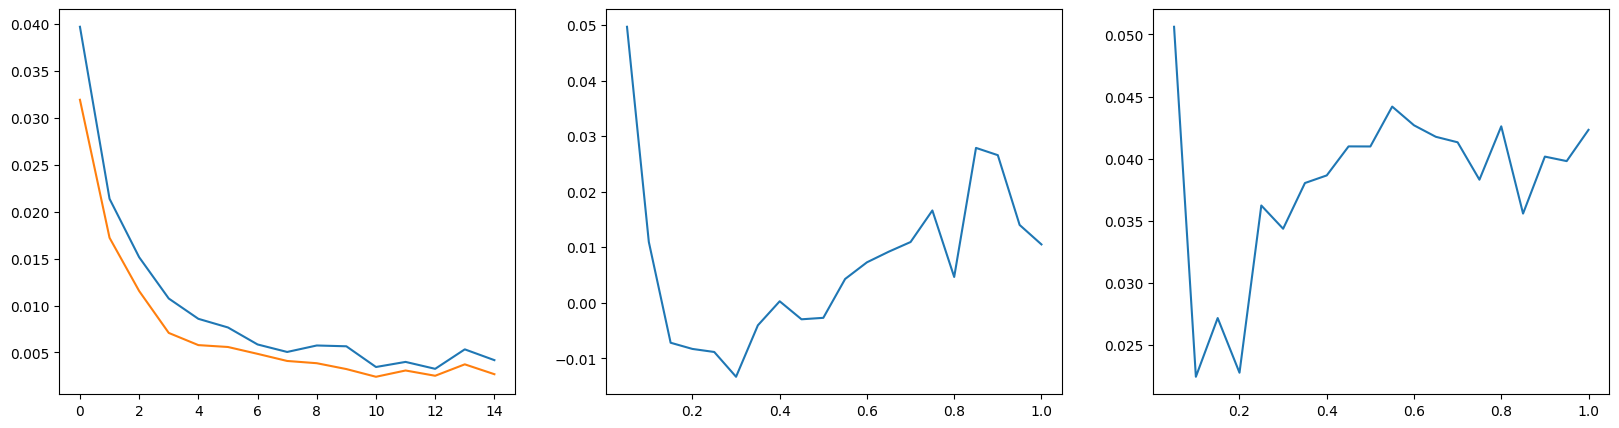

Epoch 16
-------------------------------

k-1
Avg diff: 0.044519, Avg loss: 0.002867, Min rate: -0.006260, Max rate: 1.030148  [  800/ 3630]
Avg diff: 0.045056, Avg loss: 0.003358, Min rate: 0.057851, Max rate: 1.013224  [ 1600/ 3630]
Avg diff: 0.043925, Avg loss: 0.003071, Min rate: 0.008203, Max rate: 1.018092  [ 2400/ 3630]
Avg diff: 0.043597, Avg loss: 0.002846, Min rate: -0.016249, Max rate: 1.040715  [ 3200/ 3630]
Avg diff: 0.039025, Avg loss: 0.002360, Min rate: 0.013241, Max rate: 1.044097  [ 3630/ 3630]


100%|██████████| 114/114 [00:15<00:00,  7.54it/s]



k-2


KeyboardInterrupt: 

In [16]:
for t in range(20):
    print(f"Epoch {t + 1}\n-------------------------------")

    train_results = []
    test_results = []
    for k, test_df in enumerate(samples):
        print(f"\nk-{k + 1}")
        train_df = pd.concat([sample for sample in samples if sample is not test_df], ignore_index=True)
        train_data = Dataset(train_df, transforms=train_transform)
        test_data = Dataset(test_df, transforms=test_transform)
        train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
        train_result = train_loop(train_dataloader, model, weighted_mse_loss, optimizer, batch_size)
        test_result = test_loop(test_dataloader, model, weighted_mse_loss)
        train_results.append(train_result)
        test_results.append(test_result)

    train_result = TrainResult.concat(train_results)
    test_result = TestResult.concat(test_results)
    epochs.append(t)
    train_y.append(mean(train_result.losses))
    test_y.append(test_result.loss)

    if test_result.loss < best_state['loss']:
        best_state['accuracy'] = test_result.accuracy
        best_state['loss'] = test_result.loss
        best_state['diff'] = test_result.diff
        best_state['min_rate'] = test_result.min_rate
        best_state['max_rate'] = test_result.max_rate
        best_state['max_diff'] = test_result.max_diff
        best_state['epoch'] = t + 1
        best_state['state'] = deepcopy(model.state_dict())
        torch.save(model, 'current-EfficientNetV2-S.pth')

    print(
        results_template.format(
            test_result.accuracy,
            test_result.loss,
            test_result.min_rate,
            test_result.max_rate,
            test_result.max_diff
        )
    )
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
    ax1.plot(epochs, train_y)
    ax1.plot(epochs, test_y)
    ax2.plot(test_result.df['range'], test_result.df['diffs'])
    ax3.plot(test_result.df['range'], test_result.df['abs_diffs'])
    plt.show()